Sanity check\
For verifying if the dataset scripts function as expected

In [13]:
import sys
import os

In [2]:
proj_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(proj_root, 'src')

if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
from data.dataset import build_custom_dataset
from data.sampler_utils import build_weighted_sampler

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms.v2 as T
from torchvision import datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

/Users/rainalex/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
root = '../data/split'

In [3]:
transform = T.Compose([
    T.Resize(210),
    T.CenterCrop(210),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1,0.1)),
    T.RandomRotation(20),
    T.GaussianBlur(kernel_size=3),
    T.ToTensor()
])

/Users/rainalex/anaconda3/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


# Load Data

In [7]:
torch.manual_seed(2)
train_dataset = build_custom_dataset('train', transform=transform)
sampler = build_weighted_sampler(train_dataset.samples)
val_dataset = datasets.ImageFolder(os.path.join(root, 'val'), transform=transform)

In [8]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
images, labels = next(iter(train_loader))

In [10]:
images.shape, labels.shape

(torch.Size([32, 3, 210, 210]), torch.Size([32]))

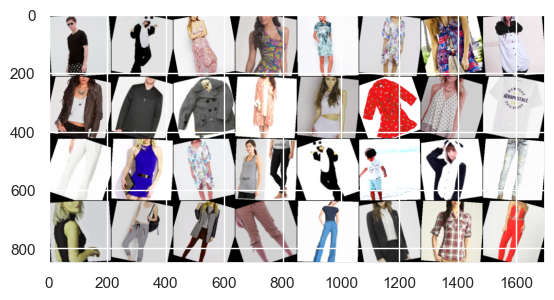

In [11]:
img_grid = make_grid(images)

plt.imshow(np.transpose(img_grid, (1, 2, 0)))

# Define model

In [12]:
(((210 - 2) / 2) - 2) / 2

51.0

In [13]:
51 * 51 * 16

41616

In [14]:
len(train_dataset.classes)

45

In [8]:
class BaseCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(51 * 51 * 16, 512)
        self.fc2 = nn.Linear(512, 120)
        self.fc3 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 51 * 51 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
torch.manual_seed(2)
base_cnn = BaseCNN(num_classes=len(train_dataset.classes))

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_cnn.parameters(), lr=0.001)

AttributeError: 'collections.OrderedDict' object has no attribute 'parameters'

In [18]:
base_cnn(images).shape

torch.Size([32, 45])

In [19]:
# TODO: train loop
epochs = 1
train_losses = []
val_losses = []

for e in range(epochs):
    for batch, (X_train, y_train) in enumerate(train_loader):
        preds_train = base_cnn(X_train)
        loss_train = criterion(preds_train, y_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        print(f"Epoch: {e:4} Batch: {batch:4} Loss: {loss_train.item():8.8f}")

    train_losses.append(loss_train.item())

    with torch.no_grad():
        for X_val, y_val in val_loader:
            preds_val = base_cnn(X_val)
            
        loss_val = criterion(preds_val, y_val)
        val_losses.append(loss_val.item())
    
    

Epoch:    0 Batch:    0 Loss: 3.80243587
Epoch:    0 Batch:    1 Loss: 3.90671468
Epoch:    0 Batch:    2 Loss: 3.98083591
Epoch:    0 Batch:    3 Loss: 3.73321676
Epoch:    0 Batch:    4 Loss: 3.96743131
Epoch:    0 Batch:    5 Loss: 4.00318289
Epoch:    0 Batch:    6 Loss: 3.99483466
Epoch:    0 Batch:    7 Loss: 3.83105850
Epoch:    0 Batch:    8 Loss: 3.81386757
Epoch:    0 Batch:    9 Loss: 3.83768606
Epoch:    0 Batch:   10 Loss: 3.83960009
Epoch:    0 Batch:   11 Loss: 3.83921456
Epoch:    0 Batch:   12 Loss: 3.85224319
Epoch:    0 Batch:   13 Loss: 3.82431459
Epoch:    0 Batch:   14 Loss: 3.83759928
Epoch:    0 Batch:   15 Loss: 3.78564596
Epoch:    0 Batch:   16 Loss: 3.80122519
Epoch:    0 Batch:   17 Loss: 3.82000899
Epoch:    0 Batch:   18 Loss: 3.82395792
Epoch:    0 Batch:   19 Loss: 3.82938981
Epoch:    0 Batch:   20 Loss: 3.83300233
Epoch:    0 Batch:   21 Loss: 3.80968952
Epoch:    0 Batch:   22 Loss: 3.80769110
Epoch:    0 Batch:   23 Loss: 3.80061603
Epoch:    0 Batc

In [20]:
torch.save(base_cnn.state_dict(), '../src/models/sanity_check.pt')

# Evaluation

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

In [33]:
torch.manual_seed(2)
test_dataset = datasets.ImageFolder(os.path.join(root, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
len(test_dataset)

4000

In [34]:
base_cnn = BaseCNN(num_classes=45)
base_cnn.load_state_dict(torch.load('../src/models/sanity_check.pt'))

<All keys matched successfully>

In [35]:
base_cnn.eval()

with torch.no_grad():
    for X_test, y_test in test_loader:
        preds = base_cnn(X_test)
        loss = criterion(preds, y_test)

        print(classification_report(y_test, preds.argmax(dim=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00       297
           3       0.01      0.75      0.02         4
           4       0.03      0.25      0.06         8
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.02      0.08      0.03        25
           9       0.00      0.00      0.00        12
          10       0.00      0.00      0.00         4
          11       0.03      0.05      0.04       198
          12       0.00      0.00      0.00        15
          13       0.00      0.00      0.00         7
          14       0.00      0.08      0.01        13
          15       0.00      0.00      0.00        64
          16       0.00      0.00      0.00       105
          17       0.04    

/Users/rainalex/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rainalex/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rainalex/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rainalex/anaconda3/l